In [1]:
import sys
sys.path.append('./BIC_codes/')
from functions.dFC_funcs import *
import numpy as np
import scipy.spatial.distance as ssd
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
import time
import os

################################# Parameters #################################

1. Set paths to the data folders and output folder, select data type, and the sessions of the data you want to include

In [2]:
output_root = './../../../../../RESULTs/methods_implementation/'

# DATA_type is either 'sample' or 'Gordon' or 'simulated' or 'ICA'
params_data_load = { \
    'DATA_type': 'Gordon', \
    'SESSIONs':['Rest1_LR'], \

    # 'data_root_simul': './../../../DATA/TVB data/', \
    # 'data_root_sample': './sampleDATA/', \
    'data_root_gordon': './sampleDATA/', \
    'data_root_ica': None 
}

2. Set the default parameter values for dFC assessment

In [3]:
params_methods = { \
    # Sliding Parameters
    # W is in sec
    'W': 44, 'n_overlap': 0.5, 'sw_method':'pear_corr', 'tapered_window':True, \
    # TIME_FREQ
    'TF_method':'WTC', \
    # CLUSTERING AND DHMM
    'clstr_base_measure':'SlidingWindow', \
    # HMM
    'hmm_iter': 50, 'n_hid_states': 24, \
    # State Parameters
    'n_states': 12, 'n_subj_clstrs': 20, \
    # Parallelization Parameters
    'n_jobs': 2, 'verbose': 0, 'backend': 'loky', \
    # SESSION
    'session': 'Rest1_LR', \
    # Hyper Parameters
    'normalization': True, \
    'num_subj': 2, \
    'num_select_nodes': 100, \
    'num_time_point': 1200, \
    'Fs_ratio': 1.00, \
    'noise_ratio': 0.00, \
    'num_realization': 1 \
}

3. Specify the list of methods you want to include:

In [4]:
MEASURES_name_lst = [ \
                'SlidingWindow', \
                # 'Time-Freq', \
                'CAP', \
                # 'ContinuousHMM', \
                'Windowless', \
                # 'Clustering', \
                # 'DiscreteHMM' \
                ]

4. You may set a list of alternative values for each parameter

In [5]:
alter_hparams = { \
            # 'session': [], \
            'n_states': [6], \
            # 'normalization': [], \
            # 'num_subj': [5], \
            # 'num_select_nodes': [50], \
            # 'num_time_point': [500], \
            # 'Fs_ratio': [0.40], \
            # 'noise_ratio': [2.00], \
            # 'num_realization': [] \
            }

5. Set parameter values for dFC Analyzer

In [6]:
params_dFC_analyzer = { \
    # VISUALIZATION
    'vis_TR_idx': list(range(10, 20, 1)),'save_image': True, 'output_root': output_root, \
    # Parallelization Parameters
    'n_jobs': 8, 'verbose': 0, 'backend': 'loky' \
}

################################# LOAD DATA #################################

Creating Data Loader object and loading the data as a Time Series object

In [7]:
data_loader = DATA_LOADER(**params_data_load)
BOLD = data_loader.load()

2 subjects were found. 
*** Session Rest1_LR: 
number of regions= 333, number of TRs= 1200


How the info dictionary of the loaded Time Series look like:

In [ ]:
BOLD['Rest1_LR'].info

################################# Measures of dFC #################################

1. Create dFC Analyzer object:

In [8]:
dFC_analyzer = DFC_ANALYZER( \
    analysis_name='reproducibility assessment', \
    **params_dFC_analyzer \
)

2. Create a list of measures with the desired default parameter values and alternative parameter values:

In [9]:
MEASURES_lst = dFC_analyzer.measures_initializer( \
    MEASURES_name_lst, \
    params_methods, \
    alter_hparams \
    )

################################# FCS estimation #################################

1. Run FCS estimation

In [10]:
tic = time.time()
print('Measurement Started ...')

MEASURES_fit_lst = list()
for measure in MEASURES_lst:

    time_series = BOLD[measure.params['session']]
    if measure.is_state_based:
        measure.estimate_FCS(time_series=time_series)
    MEASURES_fit_lst.append(measure)
            
print('Measurement required %0.3f seconds.' % (time.time() - tic, ))

dFC_analyzer.set_MEASURES_fit_lst(MEASURES_fit_lst)

Measurement Started ...
Measurement required 48.448 seconds.


OR:

1. LOAD fitted measures

In [41]:
################################# LOAD #################################
results_root = './../../../RESULTs/methods_implementation/server/methods_implementation/'
dFC_analyzer = np.load(results_root+'dFC_analyzer.npy',allow_pickle='TRUE').item()
# data_loader = np.load(results_root+'data_loader.npy',allow_pickle='TRUE').item()

################################# LOAD FIT MEASURES #################################

if dFC_analyzer.MEASURES_fit_lst==[]:
    ALL_RECORDS = os.listdir(results_root+'fitted_MEASURES/')
    ALL_RECORDS = [i for i in ALL_RECORDS if 'MEASURE' in i]
    ALL_RECORDS.sort()
    MEASURES_fit_lst = list()
    for s in ALL_RECORDS:
        fit_measure = np.load(results_root+'fitted_MEASURES/'+s,allow_pickle='TRUE').item()
        MEASURES_fit_lst.append(fit_measure)
    dFC_analyzer.set_MEASURES_fit_lst(MEASURES_fit_lst)
    print('fitted MEASURES loaded ...')

fitted MEASURES loaded ...


How info dictionary of a measure looks like:

In [ ]:
MEASURES_fit_lst[0].info

################################# dFC estimation #################################

Assess each subject's dFC using the fitted measure objects:

In [ ]:
tic = time.time()
print('Measurement Started ...')

print("dFCM estimation started...")

SUBJ_dFCM_dict = {}
for subj in range(dFC_analyzer.params_methods['num_subj']):
    subj_id = data_loader.SUBJECTS[subj]
    BOLD = data_loader.load(subj_id2load=subj_id)
    dFCM_dict = dFC_analyzer.subj_lvl_dFC_assess(time_series_dict=BOLD)
    SUBJ_dFCM_dict[subj_id] = dFCM_dict

print("dFCM estimation done.")

print('Measurement required %0.3f seconds.' % (time.time() - tic, ))

How info dictionary of the Time Series used to assess a dFCM object looks like:

In [ ]:
SUBJ_dFCM_dict[subj_id]['dFCM_lst'][0].TS_info

VISUALIZE dFC

You may filter the dFCMs you want to visualize by specifying values of parameters in param_dict:

In [14]:
dFCM_lst = SUBJ_dFCM_dict[subj_id]['dFCM_lst']

param_dict = dFC_analyzer.params_methods # the default values
# param_dict = {'Fs_ratio':0.5}
# param_dict = {'noise_ratio':1}
# param_dict = {'n_states':6, 'Fs_ratio':1.0, 'noise_ratio':0.0}
# param_dict = {'measure_name':'Clustering'}

dFCM_lst2check = filter_dFCM_lst(dFCM_lst, **param_dict)

Visualize a sample interval of assessed dFC using different measures:

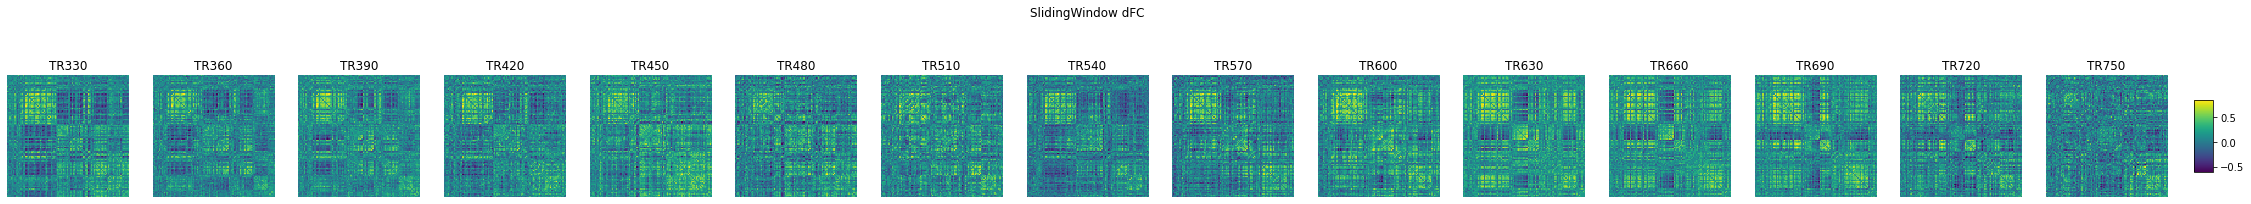

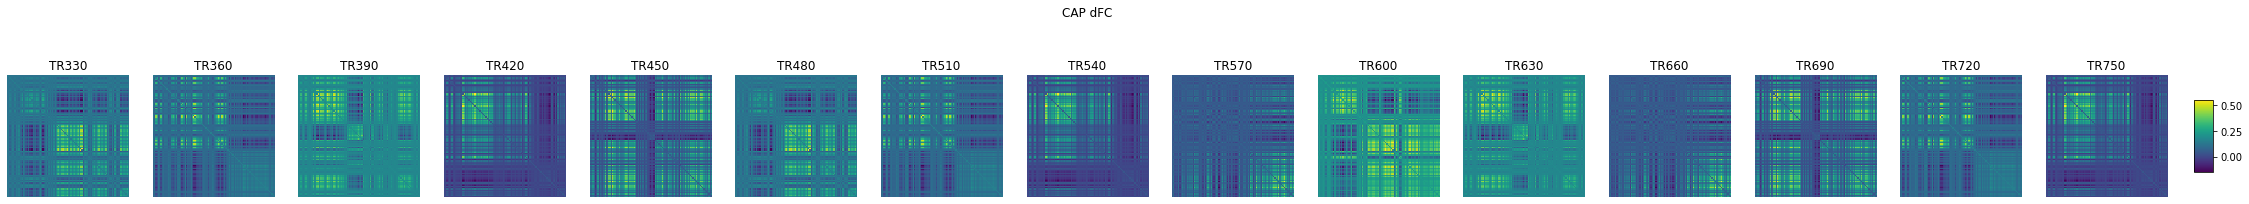

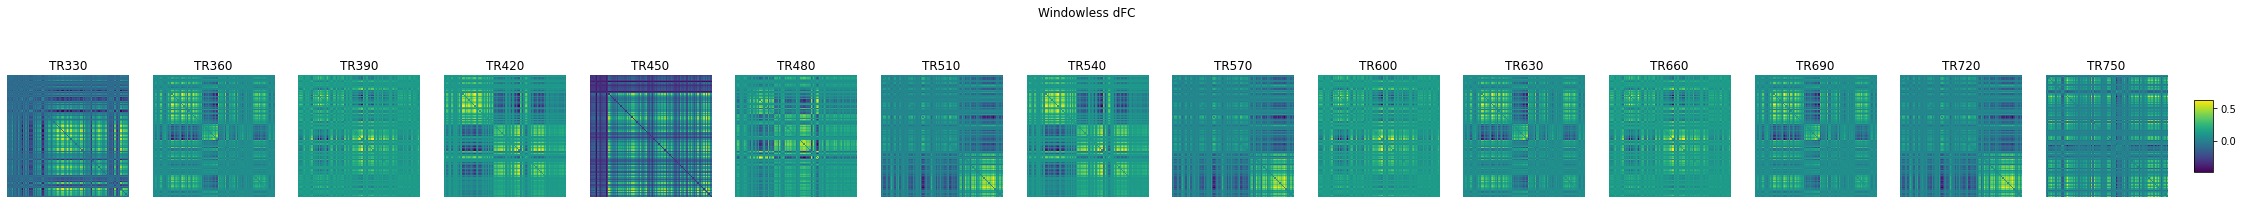

In [15]:
TRs = TR_intersection(dFCM_lst2check)
chosen_TRs = TRs[10:25]

for dFCM in dFCM_lst2check:
    dFCM.visualize_dFC(TRs=chosen_TRs, normalize=True, threshold=0.0, fix_lim=False)

################################# Post Analysis ##################################

1. RUN post analysis

In [17]:
SUBJs_output_lst = list()
for subj_id in SUBJ_dFCM_dict:
    SUBJ_output = {}

    dFCM_lst = SUBJ_dFCM_dict[subj_id]['dFCM_lst']

    analysis_name_lst = [ \
        # 'corr_mat', \
        'dFC_distance', \
        # 'dFC_distance_var', \
        # 'FO', \
        # 'CO', \
        # 'TP', \
        # 'trans_freq' \
        ]

    ########################## DEFAULT VALUES #######################

    param_dict = dFC_analyzer.params_methods
    dFCM_lst2check = filter_dFCM_lst(dFCM_lst, **param_dict)
    SUBJ_output['default_values'] = dFC_analyzer.post_analysis( \
        dFCM_lst=dFCM_lst2check, \
        analysis_name_lst=analysis_name_lst \
        )

    ########################## 6_states #######################

    param_dict = {'n_states': [6], 'is_state_based': [True]}
    dFCM_lst2check = filter_dFCM_lst(dFCM_lst, **param_dict)
    SUBJ_output['6_states'] = dFC_analyzer.post_analysis( \
        dFCM_lst=dFCM_lst2check, \
        analysis_name_lst=analysis_name_lst \
        )

    SUBJs_output_lst.append(SUBJ_output)

OR:

1. LOAD results

In [45]:
pwd

'/Users/mte/Documents/McGill/Project/dFC/CODEs/methods_implementation/git_codes'

In [48]:
assessment_results_root = './../../../RESULTs/methods_implementation/server/methods_implementation_100nodes_hyper/'

ALL_RECORDS = os.listdir(assessment_results_root+'dFC_assessed/')
ALL_RECORDS = [i for i in ALL_RECORDS if 'SUBJ_' in i]
ALL_RECORDS.sort()
SUBJs_output_lst = list()
for s in ALL_RECORDS:
    output = np.load(assessment_results_root+'dFC_assessed/'+s, allow_pickle='True').item()
    SUBJs_output_lst.append(output)

print('assessed dFCs loaded ...')

assessed dFCs loaded ...


2. VISUALIZE Similarity results

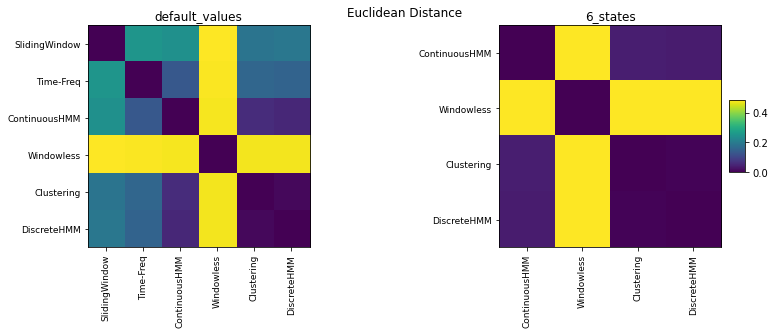

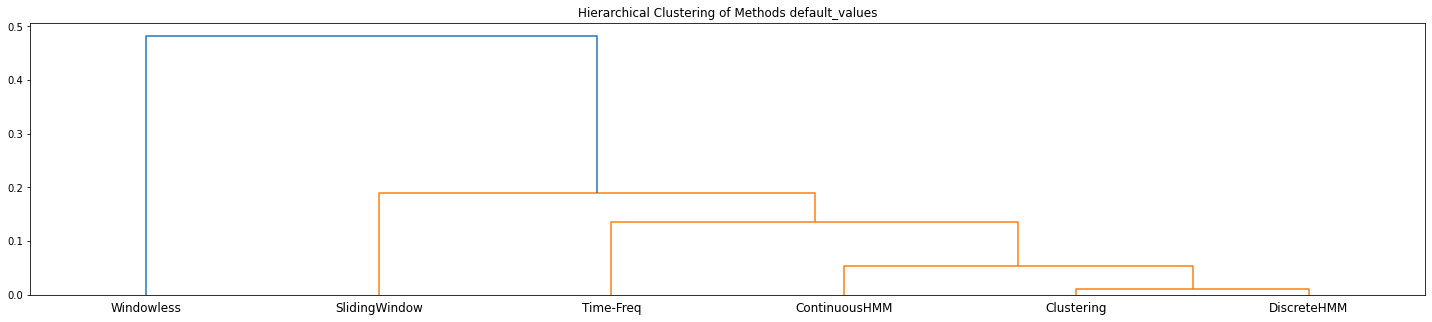

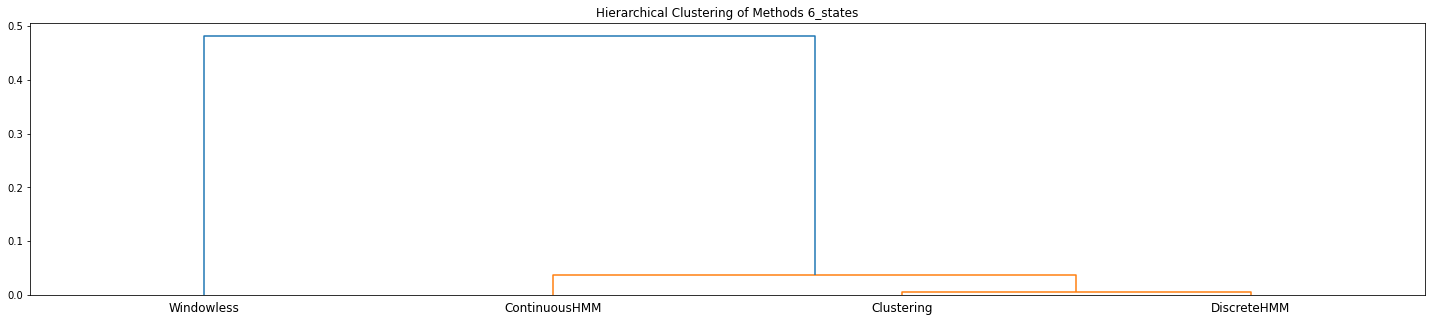

In [49]:

RESULTS = {}
for filter in ['default_values', '6_states']:

    all_subj_avg = list()
    for SUBJs_output in SUBJs_output_lst:
        avg_distance_matrix = np.mean(SUBJs_output[filter]['dFC_distance']['euclidean'], axis=0)
        all_subj_avg.append(avg_distance_matrix)

    all_subj_avg = np.array(all_subj_avg)
    all_subj_avg = np.mean(all_subj_avg, axis=0)

    RESULTS[filter] = {}
    RESULTS[filter]['corr_mat'] = all_subj_avg
    RESULTS[filter]['name_lst'] = list()
    for measure in SUBJs_output[filter]['measure_lst']:
        RESULTS[filter]['name_lst'].append(measure.measure_name)

############ Distance Matrices ############
visualize_conn_mat(RESULTS, title='Euclidean Distance', fix_lim=False, disp_diag=True, cmap='viridis', name_lst_key='name_lst', mat_key='corr_mat')

############ Hierarchical Clustering ############
for filter in RESULTS:
    # convert the redundant n*n square matrix form into a condensed nC2 array
    distArray = ssd.squareform(RESULTS[filter]['corr_mat']) 

    plt.figure(figsize=(25, 5))
    dend = shc.dendrogram(shc.linkage(distArray, method='single', metric='euclidean'), distance_sort='ascending', no_plot=False, labels=RESULTS[filter]['name_lst'])
    plt.title('Hierarchical Clustering of Methods ' + filter)